In [17]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt
import math

# random 모듈 시드 설정
random.seed(42)

# 모델 생성
model = gp.Model("pesticide_application")

# 데이터/파라미터 초기화
N = 100  # 그리드의 가로 크기
M = 100  # 그리드의 세로 크기
J = range(N * M)  # 전체 그리드 픽셀 집합
I = random.sample(J, 50)  # 농약 살포가 필요한 픽셀 집합 (랜덤으로 1000개의 픽셀 선택)
large_constant = 100000000  # 충분히 큰 상수
z_values = {j: random.randint(1, 3) for j in J}  # 각 픽셀의 z 좌표 (범위 제한: 1-3)

def calc_range():
    r = [57.73502691896256,
    63.508529610858815,
    69.28203230275507,
    75.05553499465132,
    80.8290376865476,
    86.60254037844385,
    92.3760430703401,
    98.14954576223636,
    103.92304845413261,
    109.69655114602887,
    115.47005383792512]

    return r[0]/10, r[-1]/10

r1, r2 = calc_range()

# 변수 생성
S = model.addVars(J, vtype=GRB.BINARY, name="S")  # 살포 지점 j가 선택되었는지를 나타내는 이진 변수
C = model.addVars(I, J, vtype=GRB.BINARY, name="C")  # 지점 j에 의해서 지점 i가 커버될 수 있는지를 나타내는 이진 변수
a = model.addVars(J, vtype=GRB.CONTINUOUS, name="a")

# 목적 함수 설정: 최소한의 살포 지점 선택
model.setObjective(gp.quicksum(S[j] for j in J), sense=GRB.MINIMIZE)

# 제약 조건 추가
for i in I:
    xi, yi = divmod(i, N)  # i 픽셀의 (x, y) 좌표
    for j in J:
        xj, yj = divmod(j, N)  # j 픽셀의 (x, y) 좌표
        # zj = z_values[j]  # j 픽셀의 z 좌표
        dist = math.sqrt(((xj-xi)**2 + (yj-yi)**2)) # 두 좌표간의 거리

        # i 픽셀이 j 픽셀에 의해 커버될 수 있는지에 대한 제약 조건
        model.addConstr(dist * C[i,j]<=a[j])
        # model.addConstr(xj - aj <= xi + large_constant * (1 - C[i, j]))
        # model.addConstr(xi <= xj + aj + large_constant * (1 - C[i, j]))
        # model.addConstr(yj - aj <= yi + large_constant * (1 - C[i, j]))
        # model.addConstr(yi <= yj + aj + large_constant * (1 - C[i, j]))
        model.addConstr(r1 <= a[j])
        model.addConstr(a[j]<= r2)
        model.addConstr(S[j] >= C[i, j])

# 모든 i가 적어도 하나의 j에 의해 커버되어야 한다는 제약 조건
for i in I:
    model.addConstr(gp.quicksum(C[i, j] for j in J) >= 1)

# 모델 최적화
model.optimize()



Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8279U CPU @ 2.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2000050 rows, 520000 columns and 3499950 nonzeros
Model fingerprint: 0x1206d778
Variable types: 10000 continuous, 510000 integer (510000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 50.0000000
Presolve removed 2000050 rows and 520000 columns
Presolve time: 2.39s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 2.85 seconds (2.38 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 14 50 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.400000000000e+01, best bound 1.400000000000e+01, gap 0.0000%


In [19]:
# 최적해 출력 및 시각화 준비
if model.status == GRB.OPTIMAL:
    solution = {v.varName: v.x for v in model.getVars() if v.x != 0}


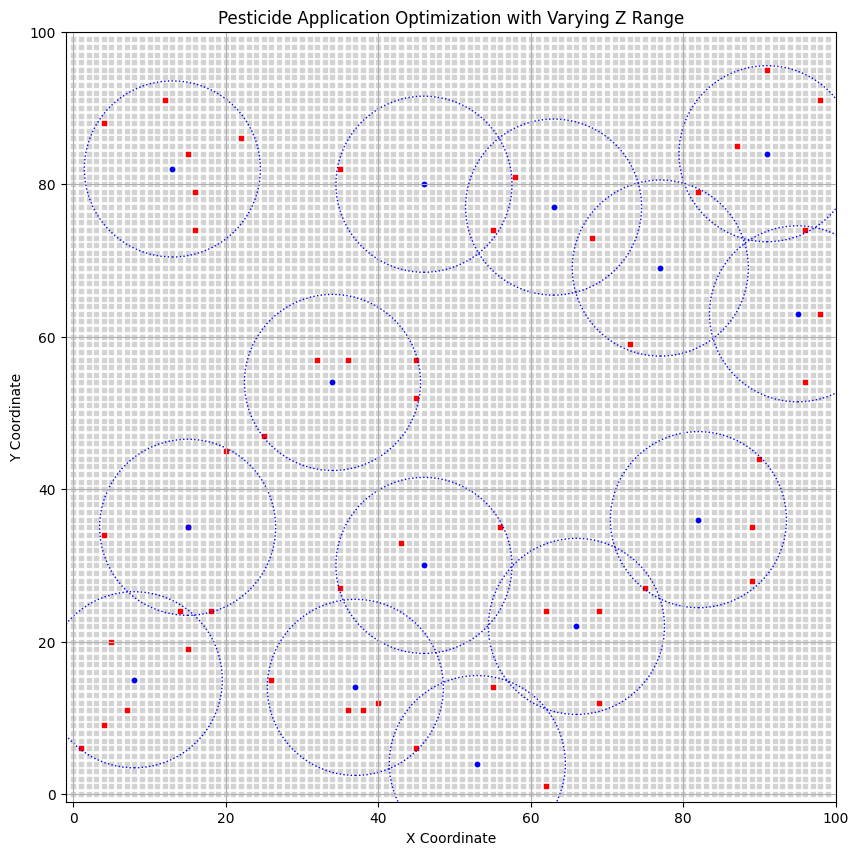

In [21]:
# 최적해 출력 및 시각화 준비
if model.status == GRB.OPTIMAL:
    # solution = {v.varName: v.x for v in model.getVars() if v.x != 0}

    # 시각화 코드
    fig, ax = plt.subplots(figsize=(12, 10))

    # 전체 그리드 픽셀
    for j in J:
        xj, yj = divmod(j, N)
        ax.scatter(xj, yj, color='lightgrey', marker='s', s=10)

    # 농약 살포가 필요한 픽셀
    for i in I:
        xi, yi = divmod(i, N)
        ax.scatter(xi, yi, color='red', marker='s', s=10)

    # 선택된 살포 지점 및 커버 범위
    for j in J:
        if S[j].x > 0.5:
            xj, yj = divmod(j, N)
            aj = a[j].x
            rect = plt.Circle((xj, yj), radius=aj, color='blue', fill=False, linestyle='dotted')
            ax.add_artist(rect)
            ax.scatter(xj, yj, color='blue', marker='o', s=10)

    plt.xlim(-1, N)
    plt.ylim(-1, M)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.title('Pesticide Application Optimization with Varying Z Range')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()
else:
    print("No optimal solution found.")

In [48]:
sx = [v.varName for v in model.getVars() if (v.x == 1) & (v.varName[0] == "S")]
sx

['S[815]',
 'S[1382]',
 'S[1535]',
 'S[3454]',
 'S[3714]',
 'S[4630]',
 'S[4680]',
 'S[5304]',
 'S[6377]',
 'S[6622]',
 'S[7769]',
 'S[8236]',
 'S[9184]',
 'S[9563]']

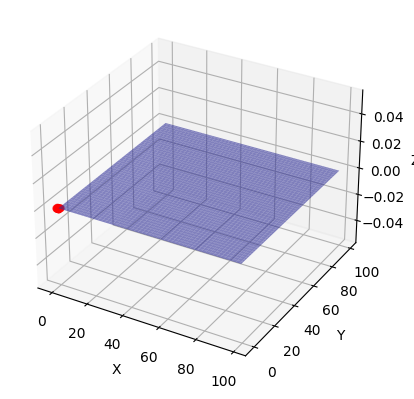

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from noise import pnoise2

# 구불구불한 곡면을 위한 Perlin 노이즈 생성
def generate_perlin_noise(x, y, scale=10, octaves=6, persistence=0.5, lacunarity=2.0):
    z = np.zeros_like(x)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i][j] = pnoise2(x[i][j] / scale,
                              y[i][j] / scale,
                              octaves=octaves,
                              persistence=persistence,
                              lacunarity=lacunarity)
    return z

# 데이터/파라미터 초기화
N = 100  # 그리드의 가로 크기
M = 100  # 그리드의 세로 크기
J = range(N * M)  # 전체 그리드 픽셀 집합
I = random.sample(J, 50)  # 농약 살포가 필요한 픽셀 집합 (랜덤으로 1000개의 픽셀 선택)

# 좌표 생성
x = range(N)
y = range(M)
x, y = np.meshgrid(x, y)

# Perlin 노이즈를 이용한 구불구불한 z 값 생성
z = generate_perlin_noise(x, y)
z = -z

xi, yi = divmod(i, N)  # i 픽셀의 (x, y) 좌표
for j in J:
    xj, yj = divmod(j, N)  # j 픽셀의 (x, y) 좌표

random_x = []
random_y = []

# 방제지점 I
for i in I:
    _x, _y = divmod(i, N)
    random_x.append(_x)
    random_y.append(_y)

# 살포지점 J
for j in J

# 실제 좌표값에서 가장 가까운 인덱스 찾기
indices = []
for i in range(num_points):
    idx_x = np.abs(x[0] - random_x[i]).argmin()
    idx_y = np.abs(y[:, 0] - random_y[i]).argmin()
    indices.append((idx_x, idx_y))

# 해당 인덱스에 대응하는 z 값 가져오기
random_z = [z[idx[1], idx[0]] for idx in indices]

# 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 곡면을 그립니다.
surf = ax.plot_surface(x, y, z, cmap='terrain', alpha=0.6)

# 랜덤한 점들을 표시합니다.
ax.scatter(random_x, random_y, random_z, c='red', marker='o')

# 축 레이블 설정
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 그래프 보이기
plt.show()
